<a href="https://colab.research.google.com/github/MaliheDahmardeh/state-house-price-analysis-SM/blob/main/state-house-price-analysis.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [334]:
import numpy as np
import pandas as pd
from datetime import datetime
from dateutil import parser
import math
import statistics
from statistics import median
from fractions import Fraction as fr
import matplotlib.pyplot as plt
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
import seaborn as sns
import plotly.express as px
from scipy import stats,signal
from scipy.stats import chi2, chi2_contingency
from sklearn.metrics import mean_squared_error, mean_absolute_error, mean_absolute_percentage_error
import statsmodels.api as sm
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn import metrics 
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score
from sklearn.preprocessing import StandardScaler

In [ ]:
#Developed on Jupyter Notebook Data Science Stack (Docker)
#!pip install pmdarima
#!pip install tbats
#!conda install gcc
#!conda install -c conda-forge prophet

In [335]:
def plotTS(df, column, loess=True, regression=True, figsize=(16,4), title='', xlabel='', ylabel='', theme = 'darkgrid', points_alpha = 0.6, custom_ylim=None):
    import numpy as np
    import seaborn as sns
    import matplotlib.pyplot as plt
    from sklearn.linear_model import LinearRegression
    from statsmodels.nonparametric.smoothers_lowess import lowess


    sns.set_style(theme)
    plt.figure(figsize=figsize)
    plt.scatter(x = df.index, y = df[column], marker='+', alpha=points_alpha, label='Data points')
    
    if loess==True:
        # model fitting
        span, sse = compute_loess_span(df.index,df[column])
        y_loess = lowess(df[column], df.index,  frac=span, it=5, return_sorted = False).T
        #plot
        plt.plot(df.index, y_loess, color='tomato', linewidth=2, label='LOESS (span={})'.format(span))
    if regression==True:
        # model fitting
        model = LinearRegression()
        x_regr = np.arange(len(df[column])).reshape(-1,1)
        model.fit(x_regr,df[column])
        coeff = model.coef_[0]
        y_predicted = model.predict(x_regr)
        #plot
        plt.plot(df.index, y_predicted, color='green', label='Regression line (coeff={})'.format(round(coeff,2)))
    #if custom_ylim != None:
        #plt.ylim(custom_ylim[0], custom_ylim[1])
    #plt.xlim(df.index[0],df.index[-1])
    plt.title(title, fontsize=14)
    plt.xlabel(xlabel)
    plt.ylabel(ylabel)
    plt.legend()
    plt.show()

In [336]:
!ls

sample_data  State_house_prices_ts.csv


In [337]:
df = pd.read_csv('State_house_prices_ts.csv', sep =',',parse_dates=['Date'])#.sort_values(by='Date', ascending=True , inplace=False)

In [338]:
display(df)
display(type(df))
display(df.dtypes)

,Date,RegionName,Price_1bedroom,Price_2bedroom,Price_3bedroom,Price_4bedroom,Price_5BedroomOrMore,Price_SingleFamilyResidence
0,2001-02-28,Alabama,70100.0,58700.0,95900.0,178700.0,248100.0,92500.0
1,2001-02-28,Alaska,97300.0,126400.0,177300.0,219800.0,282500.0,183300.0
2,2001-02-28,Arizona,75800.0,110200.0,126600.0,168100.0,250500.0,136900.0
3,2001-02-28,Arkansas,65100.0,64500.0,90300.0,156700.0,245300.0,74400.0
4,2001-02-28,California,146900.0,182700.0,218400.0,293700.0,405100.0,239900.0
...,...,...,...,...,...,...,...,...
13207,1999-12-31,Virginia,80800.0,84400.0,114300.0,191000.0,266500.0,125100.0
13208,1999-12-31,Washington,115300.0,131300.0,164400.0,218700.0,254000.0,165600.0
13209,1999-12-31,WestVirginia,NaN,NaN,60900.0,80200.0,90000.0,48100.0
13210,1999-12-31,Wisconsin,80800.0,89800.0,114400.0,143400.0,165400.0,113700.0


pandas.core.frame.DataFrame

Date                           datetime64[ns]
RegionName                             object
Price_1bedroom                        float64
Price_2bedroom                        float64
Price_3bedroom                        float64
Price_4bedroom                        float64
Price_5BedroomOrMore                  float64
Price_SingleFamilyResidence           float64
dtype: object

In [339]:
print('columns:', df.columns)
print('')
print('indexes:', df.index)
print('')
print('values:', df.values)

columns: Index(['Date', 'RegionName', 'Price_1bedroom', 'Price_2bedroom',
       'Price_3bedroom', 'Price_4bedroom', 'Price_5BedroomOrMore',
       'Price_SingleFamilyResidence'],
      dtype='object')

indexes: RangeIndex(start=0, stop=13212, step=1)

values: [[Timestamp('2001-02-28 00:00:00') 'Alabama' 70100.0 ... 178700.0
  248100.0 92500.0]
 [Timestamp('2001-02-28 00:00:00') 'Alaska' 97300.0 ... 219800.0 282500.0
  183300.0]
 [Timestamp('2001-02-28 00:00:00') 'Arizona' 75800.0 ... 168100.0
  250500.0 136900.0]
 ...
 [Timestamp('1999-12-31 00:00:00') 'WestVirginia' nan ... 80200.0 90000.0
  48100.0]
 [Timestamp('1999-12-31 00:00:00') 'Wisconsin' 80800.0 ... 143400.0
  165400.0 113700.0]
 [Timestamp('1999-12-31 00:00:00') 'Wyoming' nan ... 116600.0 nan
  104100.0]]


In [340]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 13212 entries, 0 to 13211
Data columns (total 8 columns):
 #   Column                       Non-Null Count  Dtype         
---  ------                       --------------  -----         
 0   Date                         13212 non-null  datetime64[ns]
 1   RegionName                   13212 non-null  object        
 2   Price_1bedroom               10605 non-null  float64       
 3   Price_2bedroom               11745 non-null  float64       
 4   Price_3bedroom               12787 non-null  float64       
 5   Price_4bedroom               12359 non-null  float64       
 6   Price_5BedroomOrMore         11814 non-null  float64       
 7   Price_SingleFamilyResidence  12438 non-null  float64       
dtypes: datetime64[ns](1), float64(6), object(1)
memory usage: 825.9+ KB


In [341]:
df.duplicated().sum()  

0

In [342]:
df.isnull().sum()

Date                              0
RegionName                        0
Price_1bedroom                 2607
Price_2bedroom                 1467
Price_3bedroom                  425
Price_4bedroom                  853
Price_5BedroomOrMore           1398
Price_SingleFamilyResidence     774
dtype: int64

In [343]:
a=df.loc[df.isnull().sum(axis=1) > 5]
a

,Date,RegionName,Price_1bedroom,Price_2bedroom,Price_3bedroom,Price_4bedroom,Price_5BedroomOrMore,Price_SingleFamilyResidence
16,2001-02-28,Kansas,NaN,NaN,NaN,NaN,NaN,NaN
398,2010-02-28,UnitedStates,NaN,NaN,NaN,NaN,NaN,NaN
450,2011-02-28,UnitedStates,NaN,NaN,NaN,NaN,NaN,NaN
502,2013-02-28,UnitedStates,NaN,NaN,NaN,NaN,NaN,NaN
554,2014-02-28,UnitedStates,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...
13066,1997-12-31,Alaska,NaN,NaN,NaN,NaN,NaN,NaN
13080,1997-12-31,Kansas,NaN,NaN,NaN,NaN,NaN,NaN
13120,1998-12-31,DistrictofColumbia,NaN,NaN,NaN,NaN,NaN,NaN
13128,1998-12-31,Kansas,NaN,NaN,NaN,NaN,NaN,NaN


In [344]:
a.groupby('RegionName').nunique()

,Date,Price_1bedroom,Price_2bedroom,Price_3bedroom,Price_4bedroom,Price_5BedroomOrMore,Price_SingleFamilyResidence
RegionName,,,,,,,
Alaska,10,0,0,0,0,0,0
DistrictofColumbia,10,0,0,0,0,0,0
Kansas,64,0,0,0,0,0,0
UnitedStates,95,0,0,0,0,0,0


In [345]:
df=df[(df.RegionName != 'UnitedStates')]
df=df[(df.RegionName != 'Kansas')]
df=df[(df.RegionName != 'DistrictofColumbia')]
df=df[(df.RegionName != 'Alaska')]
df=df[(df.RegionName != 'Wyoming')]
df=df[(df.RegionName != 'NorthDakota')]
df=df[(df.RegionName != 'Texas')]
df=df[(df.RegionName != 'Louisiana')]
df=df[(df.RegionName != 'Montana')]


In [346]:
df.isnull().sum()

Date                              0
RegionName                        0
Price_1bedroom                 1485
Price_2bedroom                  522
Price_3bedroom                   16
Price_4bedroom                  216
Price_5BedroomOrMore            449
Price_SingleFamilyResidence     240
dtype: int64

In [347]:
df = df.fillna(df.median())
display(df)
display(type(df))
display(df.dtypes)

,Date,RegionName,Price_1bedroom,Price_2bedroom,Price_3bedroom,Price_4bedroom,Price_5BedroomOrMore,Price_SingleFamilyResidence
0,2001-02-28,Alabama,70100.0,58700.0,95900.0,178700.0,248100.0,92500.0
2,2001-02-28,Arizona,75800.0,110200.0,126600.0,168100.0,250500.0,136900.0
3,2001-02-28,Arkansas,65100.0,64500.0,90300.0,156700.0,245300.0,74400.0
4,2001-02-28,California,146900.0,182700.0,218400.0,293700.0,405100.0,239900.0
5,2001-02-28,Colorado,118400.0,150600.0,186500.0,256200.0,302900.0,193900.0
...,...,...,...,...,...,...,...,...
13206,1999-12-31,Vermont,86000.0,97600.0,120000.0,144100.0,160800.0,145100.0
13207,1999-12-31,Virginia,80800.0,84400.0,114300.0,191000.0,266500.0,125100.0
13208,1999-12-31,Washington,115300.0,131300.0,164400.0,218700.0,254000.0,165600.0
13209,1999-12-31,WestVirginia,98400.0,112300.0,60900.0,80200.0,90000.0,48100.0


pandas.core.frame.DataFrame

Date                           datetime64[ns]
RegionName                             object
Price_1bedroom                        float64
Price_2bedroom                        float64
Price_3bedroom                        float64
Price_4bedroom                        float64
Price_5BedroomOrMore                  float64
Price_SingleFamilyResidence           float64
dtype: object

In [348]:
print('Total number of States :',df['RegionName'].nunique())
print('-------------')
print('Name of the States :',df['RegionName'].unique(),sep='\n')

Total number of States : 43
-------------
Name of the States :
['Alabama' 'Arizona' 'Arkansas' 'California' 'Colorado' 'Connecticut'
 'Delaware' 'Florida' 'Georgia' 'Hawaii' 'Idaho' 'Illinois' 'Indiana'
 'Iowa' 'Kentucky' 'Maine' 'Maryland' 'Massachusetts' 'Michigan'
 'Minnesota' 'Mississippi' 'Missouri' 'Nebraska' 'Nevada' 'NewHampshire'
 'NewJersey' 'NewMexico' 'NewYork' 'NorthCarolina' 'Ohio' 'Oklahoma'
 'Oregon' 'Pennsylvania' 'RhodeIsland' 'SouthCarolina' 'SouthDakota'
 'Tennessee' 'Utah' 'Vermont' 'Virginia' 'Washington' 'WestVirginia'
 'Wisconsin']


In [349]:
df.describe()

,Price_1bedroom,Price_2bedroom,Price_3bedroom,Price_4bedroom,Price_5BedroomOrMore,Price_SingleFamilyResidence
count,11221.000000,11221.000000,11221.000000,11221.000000,11221.000000,11221.000000
mean,112072.239551,129490.794047,164903.110240,240475.073523,308957.583994,170679.734427
std,52040.042620,63570.714790,77210.229494,97358.963352,133201.736586,89694.974051
min,30900.000000,32800.000000,49600.000000,64700.000000,68600.000000,37900.000000
25%,77400.000000,86900.000000,116500.000000,175500.000000,217000.000000,114300.000000
50%,98400.000000,112300.000000,141000.000000,218200.000000,283750.000000,145100.000000
75%,135200.000000,160700.000000,202200.000000,278900.000000,356300.000000,210200.000000
max,374500.000000,463000.000000,639700.000000,804900.000000,933900.000000,737500.000000


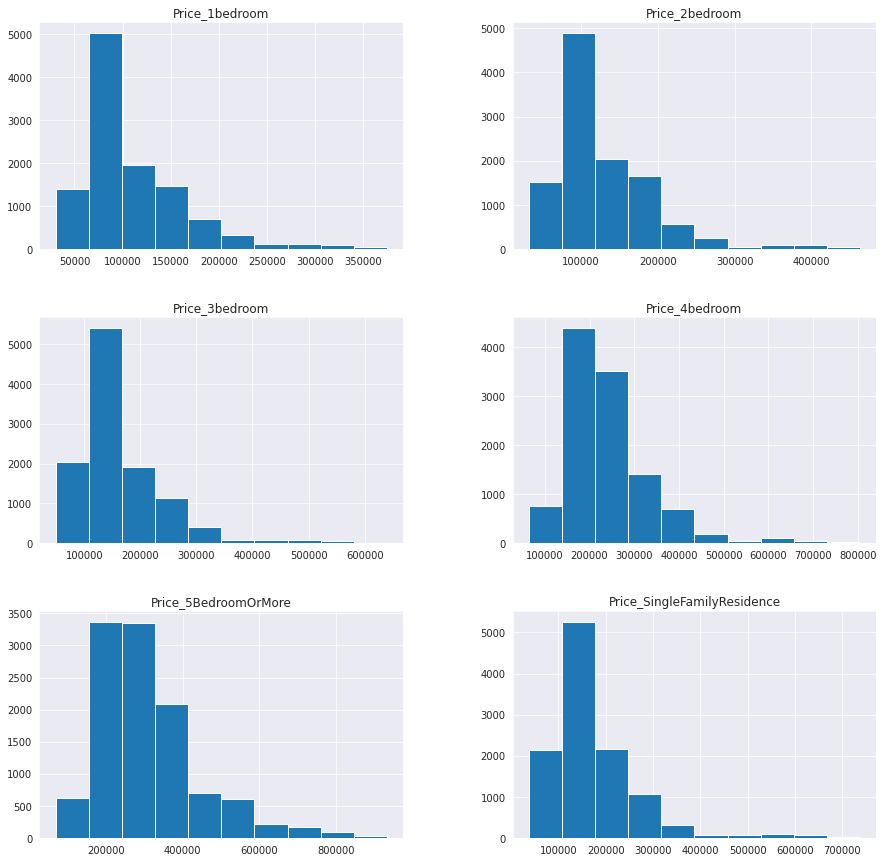

In [350]:
df_hist = df.drop(columns=['Date'],axis=1)
df_hist.hist(figsize=(15,15));

#Data manipulation

In [351]:
df['houseprice']=df['Price_1bedroom']+df['Price_2bedroom']+df['Price_3bedroom']+df['Price_4bedroom']+df['Price_5BedroomOrMore']+df['Price_SingleFamilyResidence']
house_price_by_region= pd.pivot_table(data=df, index='Date', columns='RegionName',values='houseprice')


In [352]:
display(house_price_by_region)
display(type(house_price_by_region))
display(house_price_by_region.dtypes)
display(house_price_by_region.index)

RegionName,Alabama,Arizona,Arkansas,California,Colorado,Connecticut,Delaware,Florida,Georgia,Hawaii,...,RhodeIsland,SouthCarolina,SouthDakota,Tennessee,Utah,Vermont,Virginia,Washington,WestVirginia,Wisconsin
Date,,,,,,,,,,,,,,,,,,,,,
1996-04-30,620400.0,668100.0,569900.0,991400.0,826900.0,927700.0,723100.0,625500.0,682500.0,1482200.0,...,758500.0,719250.0,NaN,593200.0,753500.0,NaN,766000.0,837300.0,431500.0,939350.0
1996-05-31,614900.0,668100.0,570700.0,988900.0,828800.0,926000.0,724200.0,626400.0,683200.0,1471400.0,...,755900.0,718050.0,524300.0,595100.0,755000.0,807200.0,766400.0,837200.0,434800.0,938750.0
1996-06-30,613100.0,669200.0,572600.0,984400.0,829600.0,926300.0,725800.0,625600.0,683400.0,1458300.0,...,753000.0,717850.0,522200.0,597400.0,757000.0,815800.0,765600.0,836900.0,439100.0,937750.0
1996-07-31,612600.0,670000.0,572900.0,980700.0,830400.0,927200.0,726400.0,624300.0,683300.0,1443500.0,...,749500.0,718150.0,520000.0,599400.0,760000.0,821900.0,764500.0,837100.0,443100.0,936650.0
1996-08-31,611800.0,670900.0,573100.0,977800.0,831300.0,926400.0,726800.0,623800.0,682800.0,1429000.0,...,746200.0,717650.0,519600.0,601600.0,764400.0,822000.0,764100.0,837400.0,445500.0,936150.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2017-08-31,1007300.0,1446500.0,1050700.0,3170600.0,2119200.0,1725200.0,1436800.0,1482200.0,1197300.0,3868900.0,...,1778600.0,1046450.0,1091100.0,1203700.0,1415800.0,1573200.0,1723900.0,2240900.0,763000.0,1053200.0
2017-09-30,1011800.0,1455300.0,1055200.0,3188700.0,2129000.0,1731800.0,1443700.0,1490900.0,1204300.0,3885100.0,...,1792400.0,1050350.0,1098300.0,1211500.0,1423600.0,1576300.0,1728900.0,2259300.0,764900.0,1058900.0
2017-10-31,1013700.0,1465100.0,1059300.0,3209600.0,2139900.0,1736500.0,1455900.0,1499300.0,1209200.0,3906800.0,...,1807000.0,1055350.0,1103900.0,1218800.0,1431900.0,1569600.0,1732100.0,2278900.0,766600.0,1063400.0


pandas.core.frame.DataFrame

RegionName
Alabama          float64
Arizona          float64
Arkansas         float64
California       float64
Colorado         float64
Connecticut      float64
Delaware         float64
Florida          float64
Georgia          float64
Hawaii           float64
Idaho            float64
Illinois         float64
Indiana          float64
Iowa             float64
Kentucky         float64
Maine            float64
Maryland         float64
Massachusetts    float64
Michigan         float64
Minnesota        float64
Mississippi      float64
Missouri         float64
Nebraska         float64
Nevada           float64
NewHampshire     float64
NewJersey        float64
NewMexico        float64
NewYork          float64
NorthCarolina    float64
Ohio             float64
Oklahoma         float64
Oregon           float64
Pennsylvania     float64
RhodeIsland      float64
SouthCarolina    float64
SouthDakota      float64
Tennessee        float64
Utah             float64
Vermont          float64
Virginia      

DatetimeIndex(['1996-04-30', '1996-05-31', '1996-06-30', '1996-07-31',
               '1996-08-31', '1996-09-30', '1996-10-31', '1996-11-30',
               '1996-12-31', '1997-01-31',
               ...
               '2017-03-31', '2017-04-30', '2017-05-31', '2017-06-30',
               '2017-07-31', '2017-08-31', '2017-09-30', '2017-10-31',
               '2017-11-30', '2017-12-31'],
              dtype='datetime64[ns]', name='Date', length=261, freq=None)

In [353]:
house_price_by_region.isnull().sum()

RegionName
Alabama          0
Arizona          0
Arkansas         0
California       0
Colorado         0
Connecticut      0
Delaware         0
Florida          0
Georgia          0
Hawaii           0
Idaho            0
Illinois         0
Indiana          0
Iowa             0
Kentucky         0
Maine            0
Maryland         0
Massachusetts    0
Michigan         0
Minnesota        0
Mississippi      0
Missouri         0
Nebraska         0
Nevada           0
NewHampshire     0
NewJersey        0
NewMexico        0
NewYork          0
NorthCarolina    0
Ohio             0
Oklahoma         0
Oregon           0
Pennsylvania     0
RhodeIsland      0
SouthCarolina    0
SouthDakota      1
Tennessee        0
Utah             0
Vermont          1
Virginia         0
Washington       0
WestVirginia     0
Wisconsin        0
dtype: int64

In [354]:
house_price_by_region = house_price_by_region.fillna(method='bfill')

In [355]:
# Converting the index as date with monthly frequency
house_price_by_region.index = pd.to_datetime(house_price_by_region.index)
house_price_by_region= house_price_by_region.asfreq('M')
display(house_price_by_region.index)
display(house_price_by_region)

DatetimeIndex(['1996-04-30', '1996-05-31', '1996-06-30', '1996-07-31',
               '1996-08-31', '1996-09-30', '1996-10-31', '1996-11-30',
               '1996-12-31', '1997-01-31',
               ...
               '2017-03-31', '2017-04-30', '2017-05-31', '2017-06-30',
               '2017-07-31', '2017-08-31', '2017-09-30', '2017-10-31',
               '2017-11-30', '2017-12-31'],
              dtype='datetime64[ns]', name='Date', length=261, freq='M')

RegionName,Alabama,Arizona,Arkansas,California,Colorado,Connecticut,Delaware,Florida,Georgia,Hawaii,...,RhodeIsland,SouthCarolina,SouthDakota,Tennessee,Utah,Vermont,Virginia,Washington,WestVirginia,Wisconsin
Date,,,,,,,,,,,,,,,,,,,,,
1996-04-30,620400.0,668100.0,569900.0,991400.0,826900.0,927700.0,723100.0,625500.0,682500.0,1482200.0,...,758500.0,719250.0,524300.0,593200.0,753500.0,807200.0,766000.0,837300.0,431500.0,939350.0
1996-05-31,614900.0,668100.0,570700.0,988900.0,828800.0,926000.0,724200.0,626400.0,683200.0,1471400.0,...,755900.0,718050.0,524300.0,595100.0,755000.0,807200.0,766400.0,837200.0,434800.0,938750.0
1996-06-30,613100.0,669200.0,572600.0,984400.0,829600.0,926300.0,725800.0,625600.0,683400.0,1458300.0,...,753000.0,717850.0,522200.0,597400.0,757000.0,815800.0,765600.0,836900.0,439100.0,937750.0
1996-07-31,612600.0,670000.0,572900.0,980700.0,830400.0,927200.0,726400.0,624300.0,683300.0,1443500.0,...,749500.0,718150.0,520000.0,599400.0,760000.0,821900.0,764500.0,837100.0,443100.0,936650.0
1996-08-31,611800.0,670900.0,573100.0,977800.0,831300.0,926400.0,726800.0,623800.0,682800.0,1429000.0,...,746200.0,717650.0,519600.0,601600.0,764400.0,822000.0,764100.0,837400.0,445500.0,936150.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2017-08-31,1007300.0,1446500.0,1050700.0,3170600.0,2119200.0,1725200.0,1436800.0,1482200.0,1197300.0,3868900.0,...,1778600.0,1046450.0,1091100.0,1203700.0,1415800.0,1573200.0,1723900.0,2240900.0,763000.0,1053200.0
2017-09-30,1011800.0,1455300.0,1055200.0,3188700.0,2129000.0,1731800.0,1443700.0,1490900.0,1204300.0,3885100.0,...,1792400.0,1050350.0,1098300.0,1211500.0,1423600.0,1576300.0,1728900.0,2259300.0,764900.0,1058900.0
2017-10-31,1013700.0,1465100.0,1059300.0,3209600.0,2139900.0,1736500.0,1455900.0,1499300.0,1209200.0,3906800.0,...,1807000.0,1055350.0,1103900.0,1218800.0,1431900.0,1569600.0,1732100.0,2278900.0,766600.0,1063400.0


#Functions(plot)

In [356]:
def compute_loess_span(x_input,y_input, steps=0.02):
    import numpy as np
    from statsmodels.nonparametric.smoothers_lowess import lowess

    best_span = 0.51
    lowest_SSE = 10e20
    
    for i in np.arange(1,51,steps*100)/100:
        span=i
        y_pred = lowess(y_input,x_input, frac=span, it=5, return_sorted = False).T
        SSE = ((y_input-y_pred)**2).sum()
        if SSE<lowest_SSE:
            best_span = i
            lowest_SSE = SSE
    return (best_span,lowest_SSE)

In [407]:
def checkHomoscedasticity(resid, return_data=False, robust=False, includeWhite=False):
    import pandas as pd
    import statsmodels.formula.api as smf
    from statsmodels.compat import lzip
    import statsmodels.stats.api as sms
    from statsmodels.stats.diagnostic import het_white
    
    resid = pd.DataFrame(resid, columns=['resid'])
    resid['step'] = range(len(resid))
    fit = smf.ols('resid ~ step', data=resid).fit()
    
    if robust==False:
        #Bresuch-Pagan test
        lagrange_mult_statistic, p_value_bp, f_value, f_p_value = sms.het_breuschpagan(fit.resid, fit.model.exog, robust=False)
        print('*** Breusch-Pagan Test ***')
        print('Lagrange multiplier statistic: ', lagrange_mult_statistic)
        print('p-value: ', p_value_bp)
        if p_value_bp > .05:
            print('Interpretation: Homoscedasticity is present, the residuals are distributed with equal variance (Ho)')
        else:
            print('Interpretation: Heteroscedasticity is present, the residuals are not distributed with equal variance (Ha)')
    else:
        #Koenker test
        lagrange_mult_statistic, p_value_bp, f_value, f_p_value = sms.het_breuschpagan(fit.resid, fit.model.exog , robust=True)
        print('*** Koenker Test ***')
        print('Lagrange multiplier statistic: ', lagrange_mult_statistic)
        print('p-value: ', p_value_bp)
        if p_value_bp > .05:
            print('Interpretation: Homoscedasticity is present, the residuals are distributed with equal variance (Ho)')
        else:
            print('Interpretation: Heteroscedasticity is present, the residuals are not distributed with equal variance (Ha)')

    if includeWhite == True:    
        #White's test
        test_stat, p_value_w, f_stat, f_p_value = het_white(fit.resid,  fit.model.exog)
        print("\n*** White's test ***")
        print('Test statistic: ', test_stat)
        print('p-value: ', p_value_w)
        if p_value_w >.05:
            print('Interpretation: Homoscedasticity is present, residuals are equally scattered (Ho)')
        else:
            print('Interpretation: Heteroscedasticity is present, residuals are not equally scattered (Ha)')
        if return_data==True:
            return (lagrange_mult_statistic,p_value_bp,test_stat, p_value_w)
    else:
        if return_data==True:
            return (lagrange_mult_statistic,p_value_bp)

In [357]:
def scalelocationPlot(resid, title='', figsize=(16,8)):
    import pandas as pd
    import statsmodels.formula.api as smf
    import numpy as np
    import seaborn as sns
    import matplotlib.pyplot as plt
    #lm
    resid = pd.DataFrame(resid, columns=['resid'])
    resid['step'] = range(len(resid))
    fit = smf.ols('resid ~ step', data=resid).fit()
    
    #get values
    model_fitted_y = fit.fittedvalues
    model_residuals = fit.resid
    model_norm_residuals = fit.get_influence().resid_studentized_internal
    model_norm_residuals_abs_sqrt = np.sqrt(np.abs(model_norm_residuals))
    
    #plot
    fig = plt.figure(3)
    fig.set_figheight(figsize[1])
    fig.set_figwidth(figsize[0])
    plt.scatter(model_fitted_y, model_norm_residuals_abs_sqrt, alpha=0.5)
    sns.regplot(model_fitted_y, model_norm_residuals_abs_sqrt, scatter=False, ci=False, lowess=True,line_kws={'color': 'red', 'lw': 2, 'alpha': 0.8})
    fig.axes[0].set_title('Scale-Location'.format(title), fontsize=14)
    fig.axes[0].set_xlabel('Fitted values')
    fig.axes[0].set_ylabel('$\sqrt{|Standardized Residuals|}$')
    plt.show()

In [358]:
def autocorrelationPlot(data, lags=30, title=''):
    from statsmodels.graphics.tsaplots import plot_pacf,plot_acf
    import matplotlib.pyplot as plt
    
    fig = plot_acf(data, lags=lags, title='Auto-correlation for the first {} lags {}'.format(lags, title));
    fig.set_figwidth(16)
    fig.set_figheight(6)
    fig = plot_pacf(data, lags=lags, title='Partial Auto-correlation for the first {} lags {}'.format(lags, title));
    fig.set_figwidth(16)
    fig.set_figheight(6)
    plt.show()

In [359]:
def qqPlot(data, title=''):
    fig = sm.qqplot(data, line ='45',fit=True,dist=stats.norm)
    fig.set_figheight(8)
    fig.set_figwidth(8)
    plt.title('Q-Q {}'.format(title))
    plt.show()

In [402]:
def checkNormality(data, return_data=False):
    from scipy.stats import shapiro, jarque_bera, normaltest, skew, kurtosis
    
    #Shapiro-Wilk
    w, p_w = shapiro(data)
    print('*** Shapiro-Wilk Test ***')
    print('W: ', w)
    print('p-value: ' , p_w)
    if p_w > .05:
        print('Interpretation: the data was drawn from a normal distribution (Ho)')
    else:
        print('Interpretation: the data was not drawn from a normal distribution (Ha)')
    
    #Jarque-Bera
    jb, p_jb = jarque_bera(data)
    print('\n*** Jarque-Bera Test ***')
    print('Jarque-Bera JB: ', jb)
    print('p-value: ' , p_jb)
    if p_jb > .05:
        print('Interpretation: the data was drawn from a normal distribution (Ho)')
    else:
        print('Interpretation: the data was not drawn from a normal distribution (Ha)')
    
    #D’Agostino-Pearson
    k2, p_k2 = normaltest(data)
    print("\n*** D’Agostino-Pearson Test ***")
    print('k2: ', k2)
    print('p-value: ' , p_k2)
    if p_k2 > .05:
        print('Interpretation: the data was drawn from a normal distribution (Ho)')
    else:
        print('Interpretation: the data was not drawn from a normal distribution (Ha)')

    print('\n----------------------------------------------------------------------')
    print('Skewness: ', skew(data))
    print('Kurtosis : ', kurtosis(data))
    
    if return_data==True:
        return (w, p_w, jb, p_jb, k2, p_k2)

#Data exploration

#How is the tren of price of houses in the united states during the years:

In [360]:
price_total = house_price_by_region.sum(axis=1)
price_total_by_year = price_total.resample('Y').sum()
price_total_by_year.index = price_total_by_year.index.year
price_total_by_year = price_total_by_year/1000000
display(price_total_by_year)

Date
1996    276.69735
1997    377.02335
1998    391.25610
1999    411.73630
2000    440.28180
2001    473.00280
2002    506.54440
2003    549.19970
2004    605.87210
2005    678.78430
2006    724.46510
2007    725.75340
2008    689.13150
2009    645.55710
2010    615.11535
2011    587.91470
2012    583.34560
2013    611.71230
2014    640.29170
2015    666.72560
2016    701.16870
2017    741.09000
dtype: float64

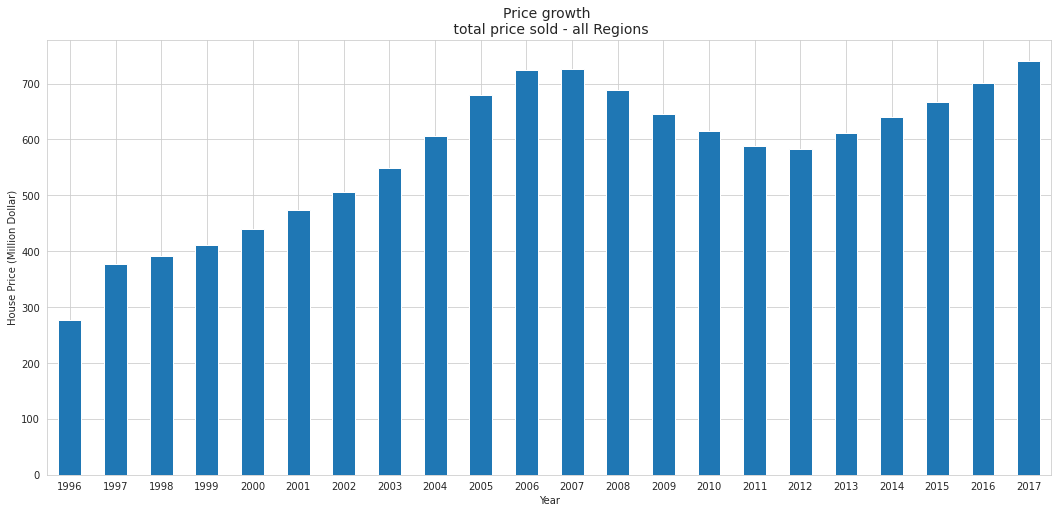

In [361]:
plt.figure(figsize=(18,8))
sns.set_style('whitegrid')
price_total_by_year.plot(kind='bar', rot=0, ylabel='House Price (Million Dollar)', xlabel='Year')
plt.title('Price growth \n total price sold - all Regions', fontsize=14)
plt.show()

#In what States the house price is more expensive:

In [362]:
price_total_by_Region = house_price_by_region.sum(axis=0)
price_total_by_regions  = pd.Series(price_total_by_Region , name='RegionName')
price_total_by_regions = price_total_by_Region.sort_values(ascending=False).head(10)

display(price_total_by_regions)

RegionName
Hawaii           671738100.0
California       567633000.0
Massachusetts    493029300.0
NewJersey        431455000.0
Connecticut      418604300.0
Washington       385042700.0
Maryland         382427500.0
RhodeIsland      372439900.0
Virginia         363337400.0
Colorado         358761100.0
dtype: float64

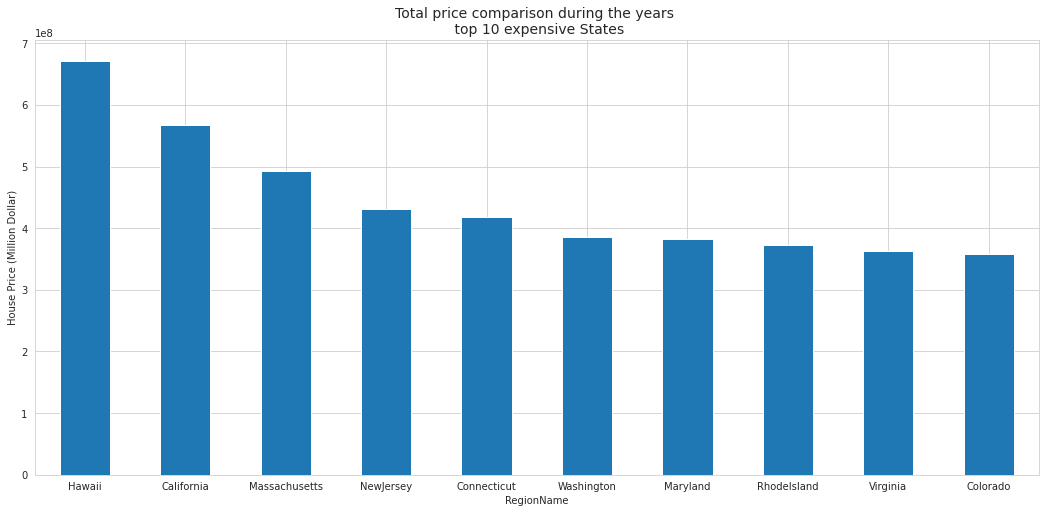

In [363]:
plt.figure(figsize=(18,8))
sns.set_style('whitegrid')
price_total_by_regions.plot(kind='bar', rot=0, ylabel='House Price (Million Dollar)', xlabel='RegionName')
plt.title('Total price comparison during the years \n top 10 expensive States', fontsize=14)
plt.show()

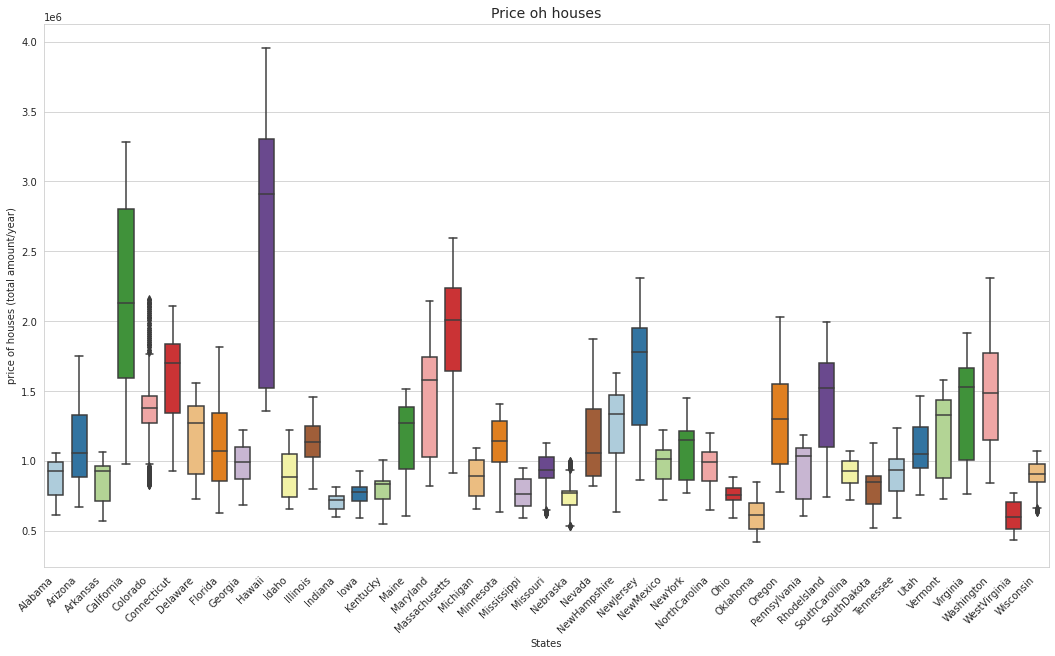

In [364]:

fig = plt.figure(figsize=(18,10))
ax  = fig.add_subplot()
sns.set_style('whitegrid')
sns.boxplot(x="RegionName", y="houseprice", data=df, palette='Paired', width=0.65)
plt.title('Price oh houses', fontsize=14)
plt.xlabel('States')
plt.setp(ax.get_xticklabels(), rotation=45, ha='right')
plt.ylabel('price of houses (total amount/year)')
plt.show()

In [365]:
price_groupby = df[['Date','RegionName','houseprice']].groupby(['Date','RegionName']).sum()
price_groupby['year'] = (price_groupby.index).to_series().map(lambda x : x[0].year)
#rice_groupby['weekday'] = (price_groupby.index).to_series().map(lambda x : x[0].isoweekday())
price_groupby['month'] = (price_groupby.index).to_series().map(lambda x : x[0].month)
display(price_groupby)

houseprice  year  month
Date       RegionName                           
1996-04-30 Alabama         620400.0  1996      4
           Arizona         668100.0  1996      4
           Arkansas        569900.0  1996      4
           California      991400.0  1996      4
           Colorado        826900.0  1996      4
...                             ...   ...    ...
2017-12-31 Vermont        1538300.0  2017     12
           Virginia       1729000.0  2017     12
           Washington     2311900.0  2017     12
           WestVirginia    764800.0  2017     12
           Wisconsin      1069900.0  2017     12

[11221 rows x 3 columns]

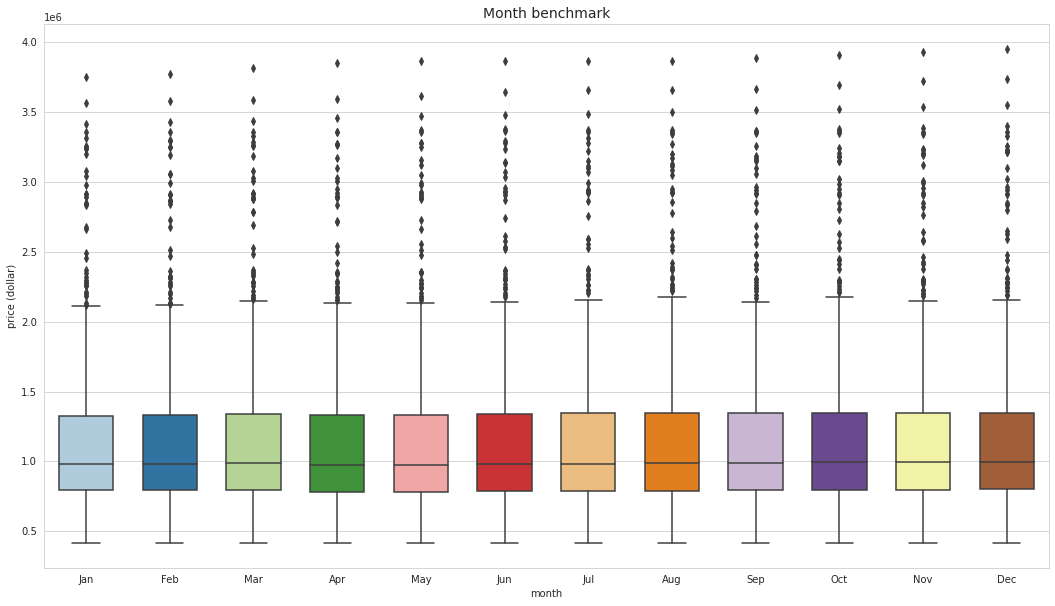

In [366]:
fig = plt.figure(figsize=(18,10))
ax  = fig.add_subplot()
sns.set_style('whitegrid')
sns.boxplot(data=price_groupby, x='month', y='houseprice', palette='Paired', width=0.65)
plt.title('Month benchmark', fontsize=14)
plt.ylabel('price (dollar)')
ax.set_xticklabels(['Jan','Feb','Mar','Apr','May','Jun','Jul','Aug','Sep','Oct','Nov','Dec'])
plt.show()

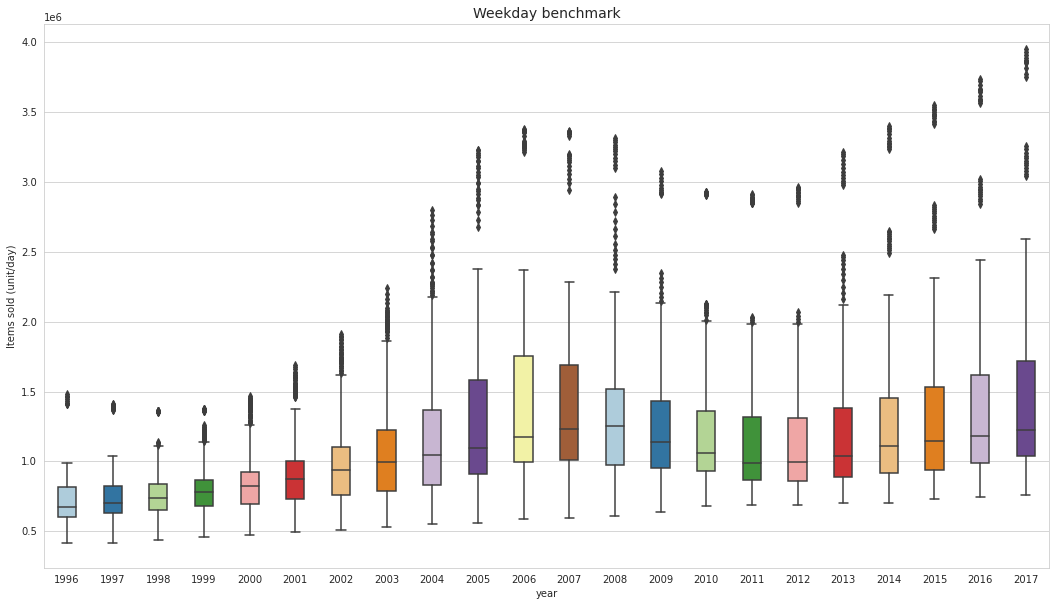

In [367]:
fig = plt.figure(figsize=(18,10))
ax  = fig.add_subplot()
sns.set_style('whitegrid')
sns.boxplot(data=price_groupby, x='year', y='houseprice', palette='Paired', width=0.4)
plt.title('Weekday benchmark', fontsize=14)
plt.ylabel('Items sold (unit/day)')
ax.set_xticklabels('{}'.format(i) for i in range(1996,2018))
plt.show()

#Discriptive Statistics-Time series Analysis

In [368]:
descriptive_stat = house_price_by_region.describe().T

Q1 = house_price_by_region.quantile(0.25)
Q3 = house_price_by_region.quantile(0.75)
IQR = Q3 - Q1

outlier_lower_count = (house_price_by_region < (Q1 - 1.5 * IQR)).sum()
outlier_upper_count = (house_price_by_region > (Q3 + 1.5 * IQR)).sum()
outlier_total_count = outlier_lower_count + outlier_upper_count

descriptive_stat['range']=descriptive_stat['max']-descriptive_stat['min']
descriptive_stat['IQR']=descriptive_stat['75%']-descriptive_stat['25%']
descriptive_stat['outlier_lower_count'] = outlier_lower_count
descriptive_stat['outlier_upper_count'] = outlier_upper_count
descriptive_stat['outlier_total_count'] = outlier_total_count

display(round(descriptive_stat,2))

,count,mean,std,min,25%,50%,75%,max,range,IQR,outlier_lower_count,outlier_upper_count,outlier_total_count
RegionName,,,,,,,,,,,,,
Alabama,261.0,875070.50,135617.28,611800.0,757600.0,926400.0,988400.0,1051900.0,440100.0,230800.0,0,0,0
Arizona,261.0,1116487.36,302705.38,668100.0,883700.0,1056600.0,1328800.0,1748900.0,1080800.0,445100.0,0,0,0
Arkansas,261.0,850105.36,145051.02,569900.0,714100.0,923700.0,963000.0,1063800.0,493900.0,248900.0,0,0,0
California,261.0,2174839.08,718250.34,976200.0,1593500.0,2130200.0,2801600.0,3280900.0,2304700.0,1208100.0,0,0,0
Colorado,261.0,1374563.60,301618.45,826900.0,1268400.0,1377000.0,1466700.0,2158900.0,1332000.0,198300.0,35,29,64
Connecticut,261.0,1603847.89,353687.60,924900.0,1343000.0,1699200.0,1834300.0,2106000.0,1181100.0,491300.0,0,0,0
Delaware,261.0,1181806.51,269770.23,723100.0,906200.0,1268900.0,1394200.0,1554000.0,830900.0,488000.0,0,0,0
Florida,261.0,1110827.20,331935.39,623100.0,852000.0,1067700.0,1339100.0,1811500.0,1188400.0,487100.0,0,0,0
Georgia,261.0,978277.78,146564.79,682500.0,868500.0,991800.0,1099800.0,1218300.0,535800.0,231300.0,0,0,0


In [369]:
Hawaii_ts = pd.DataFrame(house_price_by_region['Hawaii'])
Hawaii_ts

,Hawaii
Date,
1996-04-30,1482200.0
1996-05-31,1471400.0
1996-06-30,1458300.0
1996-07-31,1443500.0
1996-08-31,1429000.0
...,...
2017-08-31,3868900.0
2017-09-30,3885100.0
2017-10-31,3906800.0


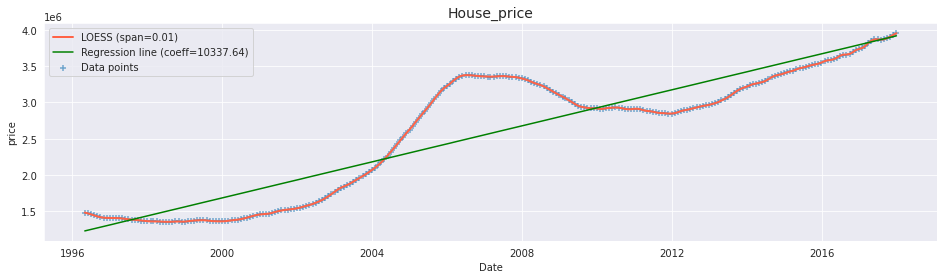

In [370]:
plotTS(Hawaii_ts, column='Hawaii', custom_ylim=(0,6000), figsize=(16,4), title='House_price', xlabel='Date', ylabel='price')

In [371]:
Alabama_ts = pd.DataFrame(house_price_by_region['Alabama'])
Alabama_ts

,Alabama
Date,
1996-04-30,620400.0
1996-05-31,614900.0
1996-06-30,613100.0
1996-07-31,612600.0
1996-08-31,611800.0
...,...
2017-08-31,1007300.0
2017-09-30,1011800.0
2017-10-31,1013700.0


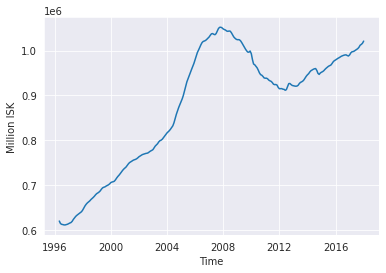

In [372]:
plt.plot(Alabama_ts)
plt.xlabel('Time')
plt.ylabel('Million ISK');

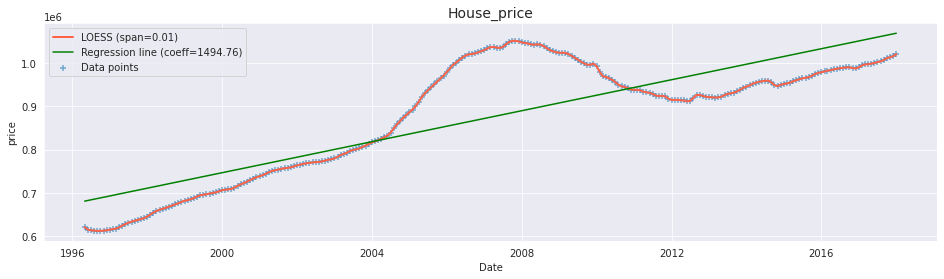

In [373]:
plotTS(Alabama_ts, column='Alabama', custom_ylim=(0,6000), title='House_price', xlabel='Date', ylabel='price')

#Analysis of State,Hawaii

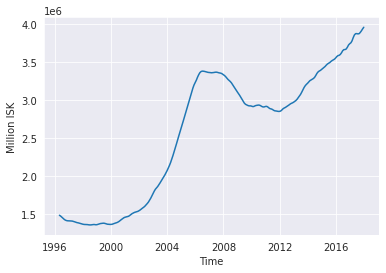

In [374]:
plt.plot(Hawaii_ts)
plt.xlabel('Time')
plt.ylabel('Million ISK');

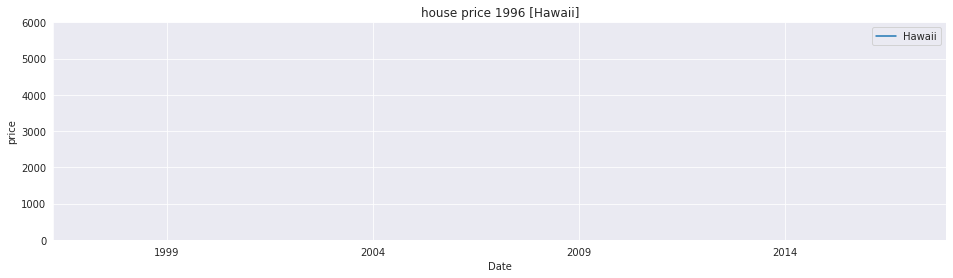

In [375]:
Hawaii_ts.plot(figsize=(16,4), title='house price 1996 [Hawaii]')
#fig.axes.title.set_size(14)
plt.xlabel('Date')
plt.ylabel('price')
plt.ylim(0,6000)
plt.show()

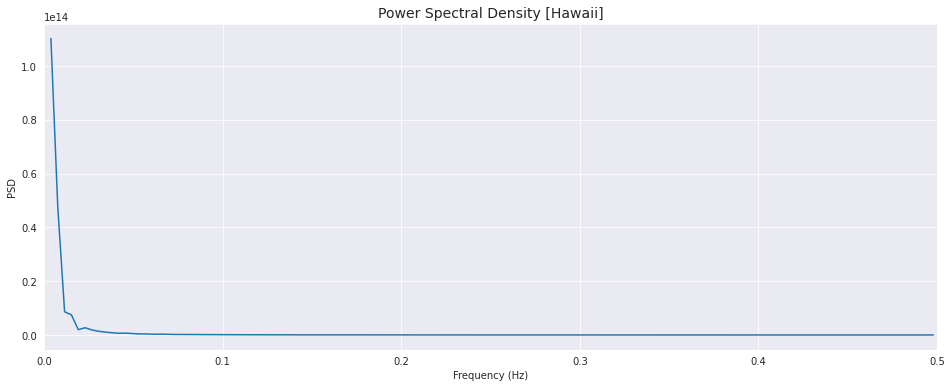

,Freq,Power,Period (year)


In [376]:
Fs = 1
f_per, Pxx_per = signal.periodogram(Hawaii_ts['Hawaii'],Fs,window=None,return_onesided=True,scaling='density')
sns.set_style('darkgrid')
plt.figure(figsize=(16,6))
plt.title('Power Spectral Density [Hawaii]', fontsize=14)
plt.plot(f_per[1:],Pxx_per[1:])
plt.xlabel('Frequency (Hz)')
plt.ylabel('PSD')

f_per = f_per[1:]
Pxx_per = Pxx_per[1:]
peaks = signal.find_peaks(Pxx_per[ f_per >= 0], prominence=np.quantile(Pxx_per, 0.99))[0]
peaks_freq = f_per[peaks]
peaks_power = Pxx_per[peaks]
plt.plot(peaks_freq, peaks_power, 'ro')
plt.xlim(0,0.5)
plt.show()

data = {'Freq':peaks_freq, 'Power':peaks_power}
df_PSD = pd.DataFrame(data)
df_PSD['Period (year)'] = 1/df_PSD['Freq']
display(df_PSD)

#Stationarity

In [377]:
def checkStationarity(data, kpss_type = 'ct', return_data=False, ci=.95):
    alpha = 1-ci
    
    if kpss_type in ['c','ct']:
        import warnings
        warnings.filterwarnings('ignore')
        from statsmodels.tsa.stattools import adfuller
        from statsmodels.tsa.stattools import kpss

        adf_test = adfuller(data,autolag='AIC')
        print('*** ADF Test ***')
        print('ADF Statistic: ', adf_test[0])
        print('p-value: ', adf_test[1])
        if adf_test[1] > alpha:
            print('Interpretation: The time series is non-stationary (Ho)')
        else:
            print('Interpretation: The time series is stationary (Ha)')

        kpss_test = kpss(data, regression=kpss_type, store=True)
        print('\n*** KPSS Test ***')
        print('KPSS Statistic:', kpss_test[0])
        print('p-value: ', kpss_test[1])

        if kpss_type == 'c':
            if kpss_test[1] > alpha:
                print('Interpretation: The time series is stationary (Ho)')
            else:
                print('Interpretation: The time series is not stationary (Ha)')
        if kpss_type == 'ct':
            if kpss_test[1] > alpha:
                print('Interpretation: The time series is trend stationary (Ho)')
            else:
                print('Interpretation: The time series is not trend stationary (Ha)')
    else:
        print('KPSS type shuld be c or ct!')
        print('c: checks if time series is stationary \nct: checks if time series is trend stationary')
    
    if return_data==True:
        return (adf_test[0],adf_test[1],kpss_test[0],kpss_test[1])

In [378]:
checkStationarity(Hawaii_ts['Hawaii'], kpss_type='c')

*** ADF Test ***
ADF Statistic:  -0.9812680163361206
p-value:  0.7600349062134676
Interpretation: The time series is non-stationary (Ho)

*** KPSS Test ***
KPSS Statistic: 1.3861937312012766
p-value:  0.01
Interpretation: The time series is not stationary (Ha)


In [379]:
checkStationarity(Hawaii_ts['Hawaii'], kpss_type='ct')

*** ADF Test ***
ADF Statistic:  -0.9812680163361206
p-value:  0.7600349062134676
Interpretation: The time series is non-stationary (Ho)

*** KPSS Test ***
KPSS Statistic: 0.19044060424763584
p-value:  0.019584773407136557
Interpretation: The time series is not trend stationary (Ha)


In [380]:
def checkAutorcorrelation(resid, lags=36, return_data=False):
    import pandas as pd
    import statsmodels.formula.api as smf
    import statsmodels.api as sm
    import statsmodels.stats.diagnostic as dg
    
    #Ljung-Box
    lb_result = sm.stats.acorr_ljungbox(resid, lags=[lags], return_df=False)
    print("*** Ljung-Box Test [{} lags] ***".format(lags))
    print('Q: ', lb_result[0][0])
    print('p-value: ' , lb_result[1][0])
    if lb_result[1][0]>.05:
        print('Interpretation: the residuals are independently distributed (Ho)')
    else:
        print('Interpretation: The residuals are not independently distributed, they exhibit serial correlation (Ha)')
    
    #Breusch-Godfrey
    resid = pd.DataFrame(resid, columns=['resid'])
    resid['step'] = range(len(resid))
    fit = smf.ols('resid ~ step', data=resid).fit()
    bg_result = dg.acorr_breusch_godfrey(fit, nlags=lags)
    print('\n*** Breusch-Godfrey Test [{} lags] ***'.format(lags))
    print('Lagrange multiplier statistic: ', bg_result[0])
    print('p-value: ', bg_result[1])
    if bg_result[1]>.05:
        print('Interpretation: there is no autocorrelation at any order less than or equal to p (Ho)')
    else:
        print('Interpretation: There exists autocorrelation at some order less than or equal to p (Ha)')
    
    if return_data==True:
        return (lb_result[0][0], lb_result[1][0], bg_result[0], bg_result[1])

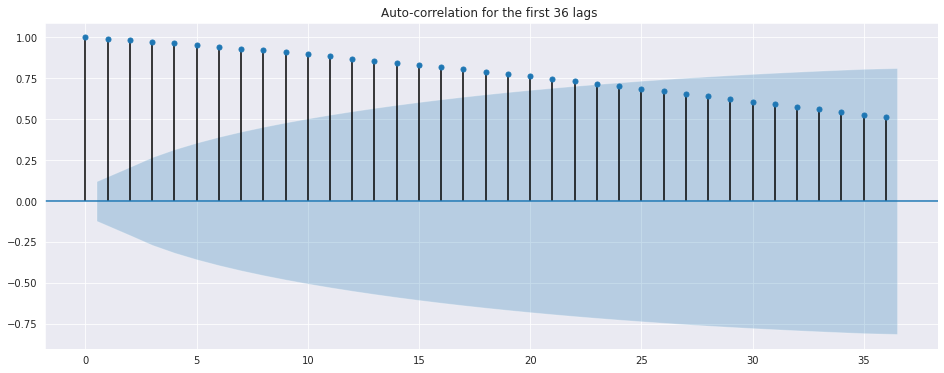

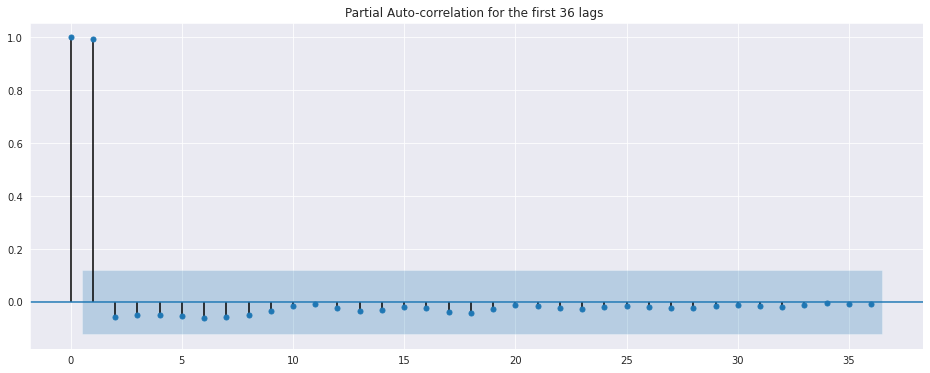

*** Ljung-Box Test [36 lags] ***
Q:  6206.401860763039
p-value:  0.0
Interpretation: The residuals are not independently distributed, they exhibit serial correlation (Ha)

*** Breusch-Godfrey Test [36 lags] ***
Lagrange multiplier statistic:  260.318224281947
p-value:  8.469062156007633e-36
Interpretation: There exists autocorrelation at some order less than or equal to p (Ha)


In [381]:

autocorrelationPlot(Hawaii_ts['Hawaii'], lags=36)
checkAutorcorrelation(Hawaii_ts['Hawaii'].values, lags=36)

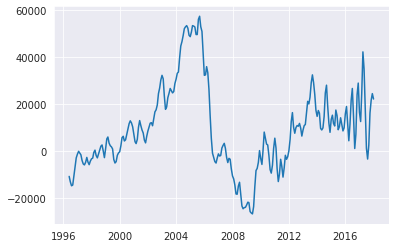

In [382]:
Hawaii_ts['diff_o1'] = np.append([np.nan],np.diff(Hawaii_ts['Hawaii'], n=1))
difference1 = Hawaii_ts['diff_o1'].dropna()
plt.plot(difference1)

In [383]:
checkStationarity(difference1, kpss_type='c')

*** ADF Test ***
ADF Statistic:  -2.302344626368526
p-value:  0.1712128979054191
Interpretation: The time series is non-stationary (Ho)

*** KPSS Test ***
KPSS Statistic: 0.1320144533985329
p-value:  0.1
Interpretation: The time series is stationary (Ho)


In [384]:
checkStationarity(difference1, kpss_type='ct')

*** ADF Test ***
ADF Statistic:  -2.302344626368526
p-value:  0.1712128979054191
Interpretation: The time series is non-stationary (Ho)

*** KPSS Test ***
KPSS Statistic: 0.13293344976959656
p-value:  0.07419731524148784
Interpretation: The time series is trend stationary (Ho)


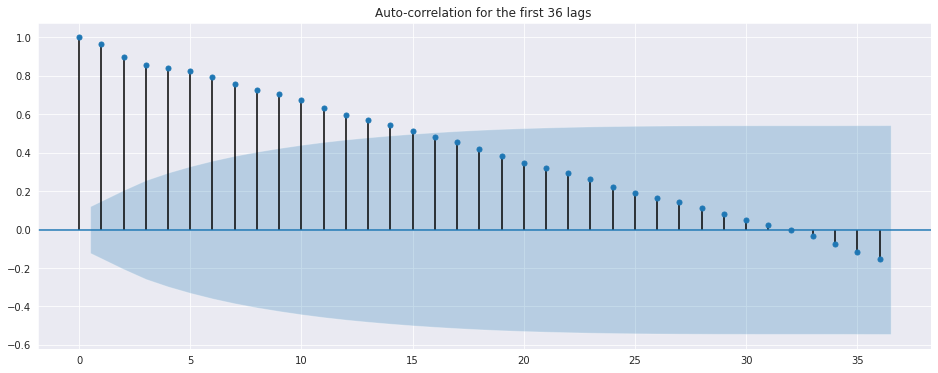

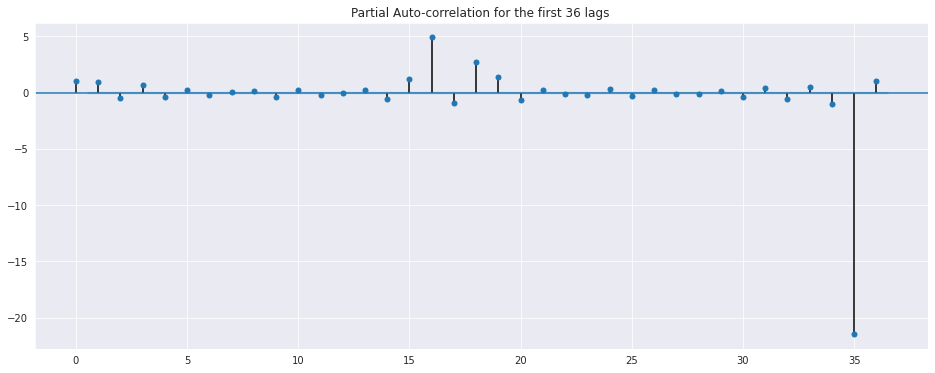

*** Ljung-Box Test [36 lags] ***
Q:  2579.623313049075
p-value:  0.0
Interpretation: The residuals are not independently distributed, they exhibit serial correlation (Ha)

*** Breusch-Godfrey Test [36 lags] ***
Lagrange multiplier statistic:  252.0559512113782
p-value:  3.0615158708764556e-34
Interpretation: There exists autocorrelation at some order less than or equal to p (Ha)


In [385]:

autocorrelationPlot(difference1, lags=36)
checkAutorcorrelation(difference1.values, lags=36)

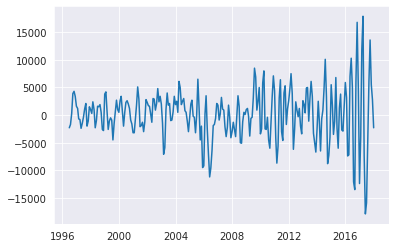

In [386]:
Hawaii_ts['diff_o2'] = np.append([np.nan] * 2,np.diff(Hawaii_ts['Hawaii'], n=2))
difference2 = Hawaii_ts['diff_o2'].dropna()
plt.plot(difference2)

In [387]:
checkStationarity(difference2, kpss_type='c')

*** ADF Test ***
ADF Statistic:  -4.780085694720618
p-value:  5.936280802869571e-05
Interpretation: The time series is stationary (Ha)

*** KPSS Test ***
KPSS Statistic: 0.07721783263798201
p-value:  0.1
Interpretation: The time series is stationary (Ho)


In [388]:
checkStationarity(difference2, kpss_type='ct')

*** ADF Test ***
ADF Statistic:  -4.780085694720618
p-value:  5.936280802869571e-05
Interpretation: The time series is stationary (Ha)

*** KPSS Test ***
KPSS Statistic: 0.07393468305540667
p-value:  0.1
Interpretation: The time series is trend stationary (Ho)


#decomposition

In [398]:
from statsmodels.tsa.seasonal import seasonal_decompose

In [399]:
#extracting Monthly seasonality
sd_week = seasonal_decompose(Hawaii_ts['Hawaii'], model='additive', period=1, two_sided=True)
#extracting yearly seasonality from time series adjusted by Monthly seasonality
sd_year = seasonal_decompose(Hawaii_ts['Hawaii'] -  sd_week.seasonal, model='additive', period=12, two_sided=True)

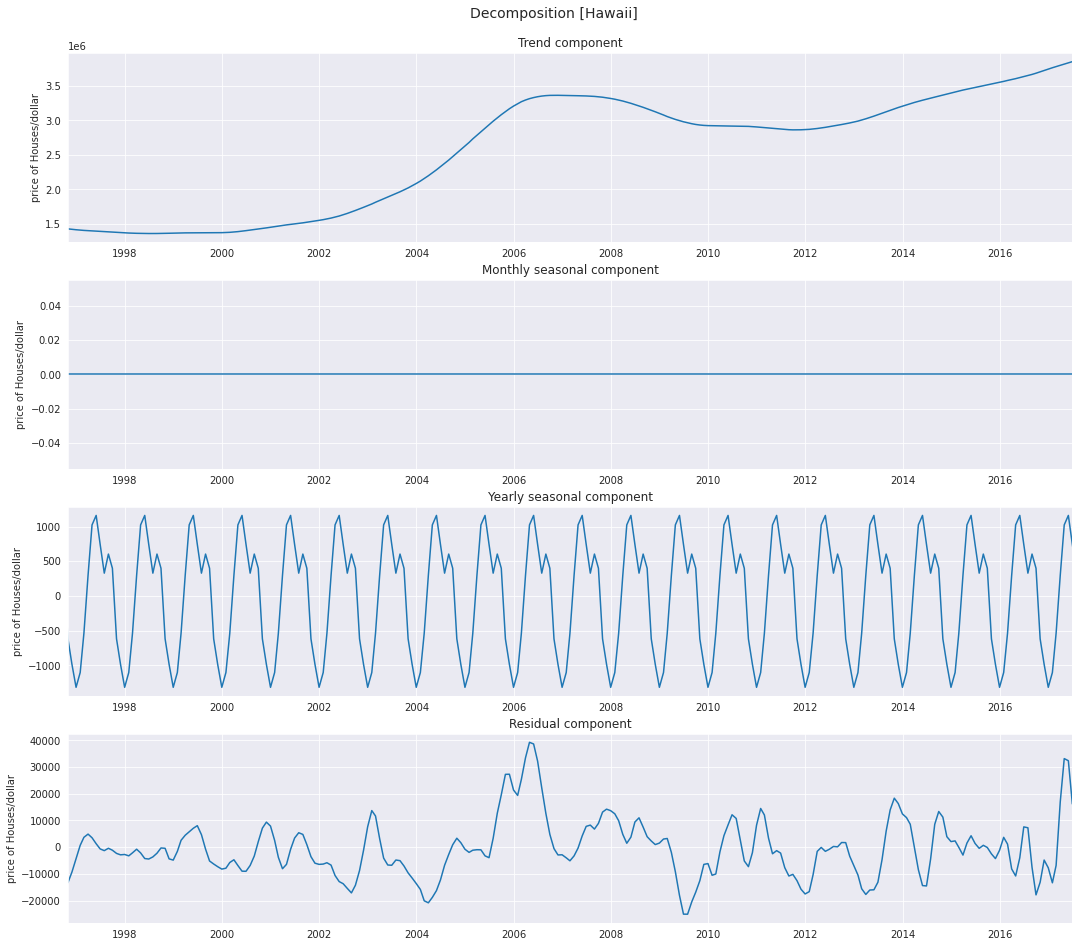

In [400]:
f, axes = plt.subplots(4,1,figsize=(18,16))
plt.suptitle('Decomposition [Hawaii]', y=0.92, fontsize=14)

#plotting trend component
axes[0].plot(sd_year.trend)
axes[0].set_title('Trend component', fontdict={'fontsize': 12})

#plotting weekly seasonal component
axes[1].plot(sd_week.seasonal)
axes[1].set_title('Monthly seasonal component', fontdict={'fontsize': 12})

#plotting yearly seasonal component
axes[2].plot(sd_year.seasonal)
axes[2].set_title('Yearly seasonal component', fontdict={'fontsize': 12})

#plotting residual of decomposition
axes[3].plot(sd_year.resid)
axes[3].set_title('Residual component', fontdict={'fontsize': 12})

for a in axes:
    a.set_ylabel('price of Houses/dollar')
    a.set_xlim(sd_year.trend.dropna().index[0], sd_year.trend.dropna().index[-1])

#showing chart
plt.show()

#dec-residual

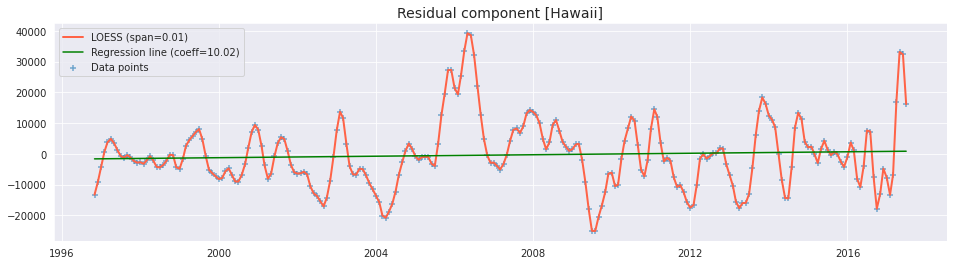

In [401]:
decomp_residuals = pd.DataFrame(sd_year.resid.dropna())
plotTS(decomp_residuals, column='resid', figsize=(16,4), title='Residual component [Hawaii]')

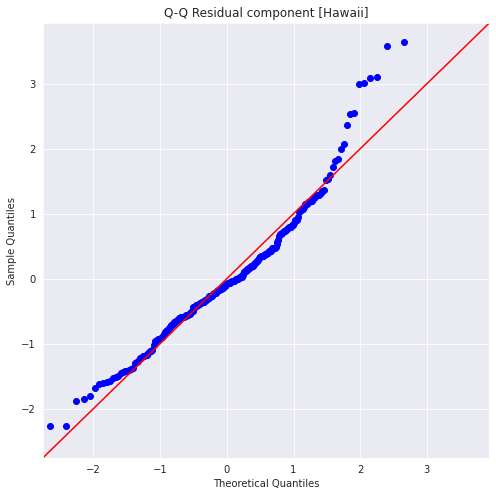

*** Shapiro-Wilk Test ***
W:  0.9566412568092346
p-value:  8.384466809729929e-07
Interpretation: the data was not drawn from a normal distribution (Ha)

*** Jarque-Bera Test ***
Jarque-Bera JB:  54.63656100191381
p-value:  1.3671286325234178e-12
Interpretation: the data was not drawn from a normal distribution (Ha)

*** D’Agostino-Pearson Test ***
k2:  [35.43434208]
p-value:  [2.0208328e-08]
Interpretation: the data was not drawn from a normal distribution (Ha)

----------------------------------------------------------------------
Skewness:  [0.83630829]
Kurtosis :  [1.57115509]


In [403]:
qqPlot(decomp_residuals['resid'], title='Residual component [Hawaii]')
checkNormality(decomp_residuals)

In [404]:
checkStationarity(decomp_residuals, kpss_type='c')

*** ADF Test ***
ADF Statistic:  -3.905664464371959
p-value:  0.0019935530025647456
Interpretation: The time series is stationary (Ha)

*** KPSS Test ***
KPSS Statistic: 0.0879055814389594
p-value:  0.1
Interpretation: The time series is stationary (Ho)


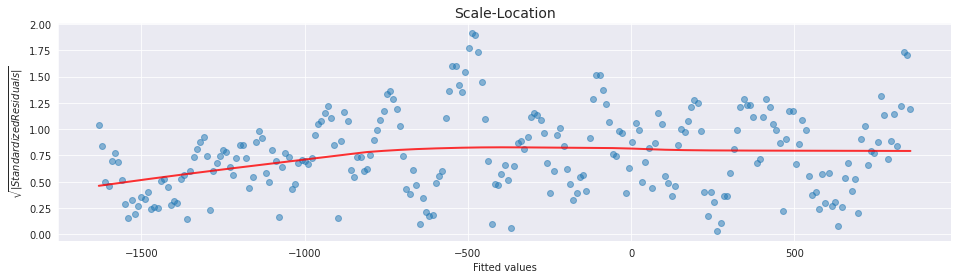

*** Koenker Test ***
Lagrange multiplier statistic:  4.6619461750298035
p-value:  0.030838218215414177
Interpretation: Heteroscedasticity is present, the residuals are not distributed with equal variance (Ha)


In [408]:
scalelocationPlot(decomp_residuals['resid'], figsize=(16,4))
checkHomoscedasticity(decomp_residuals, robust=True)

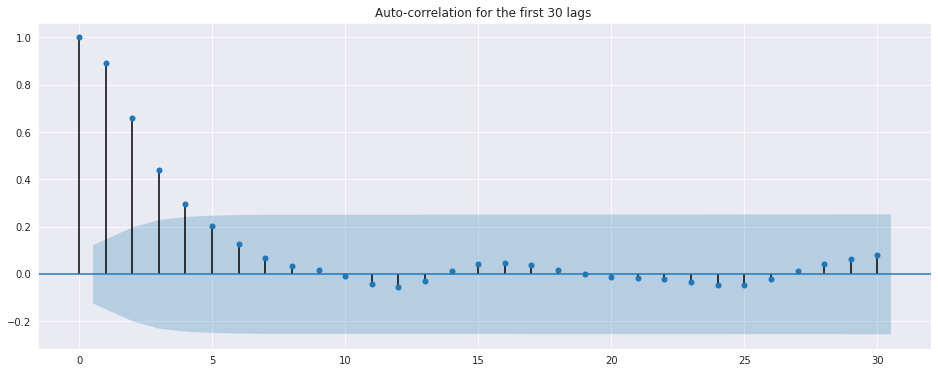

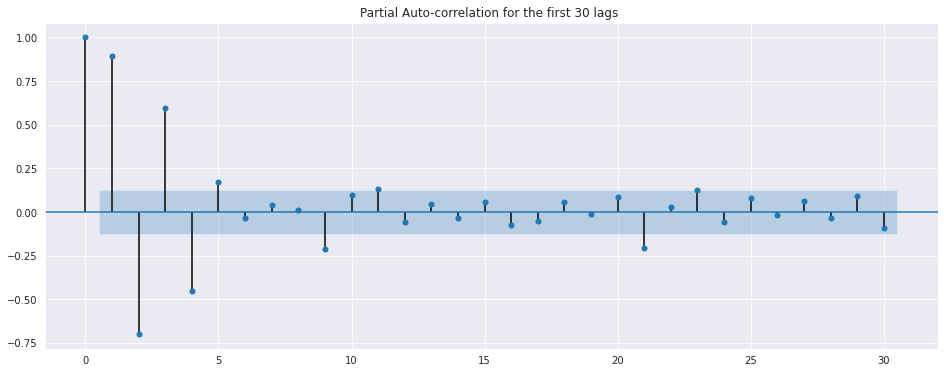

*** Ljung-Box Test [30 lags] ***
Q:  407.04476763148034
p-value:  1.0526845706455671e-67
Interpretation: The residuals are not independently distributed, they exhibit serial correlation (Ha)

*** Breusch-Godfrey Test [30 lags] ***
Lagrange multiplier statistic:  232.921038338111
p-value:  2.9039471382245547e-33
Interpretation: There exists autocorrelation at some order less than or equal to p (Ha)


In [406]:
autocorrelationPlot(decomp_residuals['resid'], lags=30)
checkAutorcorrelation(decomp_residuals, lags=30)

In [394]:
# Train and test 
data_train = Hawaii_ts[:-24]['Hawaii'] 
data_test = Hawaii_ts[-24:]['Hawaii']

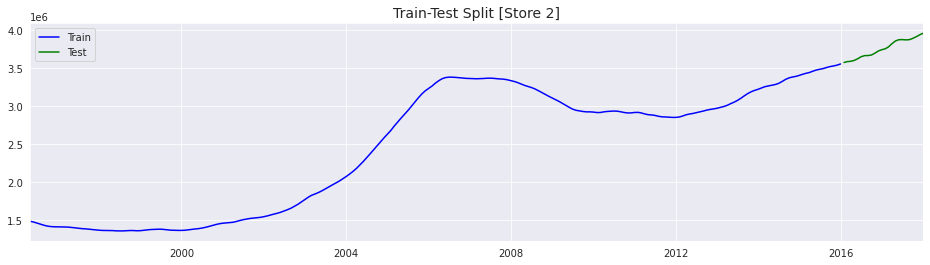

In [396]:
plt.figure(figsize=(16,4))
plt.plot(data_train, color='blue', label='Train')
plt.plot(data_test, color='green', label='Test')
plt.xlim(data_train.index[0],data_test.index[-1])
plt.title('Train-Test Split [Store 2]', fontsize=14)
plt.legend()
plt.show()

In [ ]:
!pip install pmdarima

In [410]:
from pmdarima import auto_arima

In [ ]:
Y_train = Hawaii_ts[:-24]['Hawaii'] 
X_train = X[:-24]
Y_test = Hawaii_ts[-24:]['Hawaii'] 
X_test = X[-24:]